Copyright © 2025 Technical University of Denmark

In [1]:
from lcg_plus.base import State
from thewalrus.symplectic import squeezing, beam_splitter, rotation, expand, xxpp_to_xpxp 
import numpy as np
from lcg_plus.fidelity import overlap_log
from lcg_plus.states.from_sf import prepare_gkp_bosonic
from lcg_plus.states.nongauss import prepare_gkp_nonlinear_sqz, prepare_sqz_cat_coherent
import itertools as it
from lcg_plus.plotting import plot_wigner_marginals
from matplotlib import pyplot as plt

In [2]:
beam_splitter(-np.pi/4,0)

array([[ 0.70710678,  0.70710678, -0.        ,  0.        ],
       [-0.70710678,  0.70710678, -0.        , -0.        ],
       [ 0.        , -0.        ,  0.70710678,  0.70710678],
       [ 0.        ,  0.        , -0.70710678,  0.70710678]])

In [3]:
def cz_gate(g):
    return np.array([[1,0,0,0],[0,1,g,0],[0,0,1,0],[g,0,0,1]])

In [4]:
def teleportation_circuit_EPR(r, phi1, phi2, input_state, m1 = 0, m2 = 0):
    """
    Args:
        r : float, squeezing of EPR state
        phi1 : homodyne angle 1
        phi2 : homodyne angle 2
        input_state : input state  (bosonicplus.base.State)
        m1 : measurement result
        m2 : measurement result 
    """
    S2 = xxpp_to_xpxp(squeezing(r,0))
    S3 = xxpp_to_xpxp(squeezing(r,np.pi))
    BS = xxpp_to_xpxp(beam_splitter(-np.pi/4,0))

    ## hack to tensor product two mode vacuum with the input state
    new_means = np.array([np.concatenate([i, np.zeros(4)]) for i in input_state.means])
    new_covs = np.array([np.eye(6)])
    new_covs[:,0:2,0:2] = input_state.covs
    state = State(3)
    state.update_data([new_means, new_covs, input_state.log_weights, input_state.num_k])
    
    #make the ancilla EPR state
    state.apply_symplectic_fast(S2, [1])
    state.apply_symplectic_fast(S3, [2])
    state.apply_symplectic_fast(BS, [1,2])

    state.apply_symplectic_fast(BS, [0,1])

    state.post_select_homodyne(0, phi1, m1)
    state.post_select_homodyne(0, phi2, m2)

    return state


In [5]:
def teleportation_circuit_cluster(r, g, phi1, phi2, input_state, m1 = 0, m2 = 0):
    """
    Args:
        r : float, squeezing in momentum
        t : cz-gate strength
        phi1 : homodyne angle 1
        phi2 : homodyne angle 2
        input_state : input state  (bosonicplus.base.State)
        m1 : measurement result
        m2 : measurement result
    """
    S2 = xxpp_to_xpxp(squeezing(r,np.pi))
    S3 = xxpp_to_xpxp(squeezing(r,np.pi))
    CZ = cz_gate(g)
    BS = xxpp_to_xpxp(beam_splitter(-np.pi/4,0))

    ## hack to tensor product two mode vacuum with the input state
    new_means = np.array([np.concatenate([i, np.zeros(4)]) for i in input_state.means])
    new_covs = np.array([np.eye(6)])
    new_covs[:,0:2,0:2] = input_state.covs
    state = State(3)
    state.update_data([new_means, new_covs, input_state.log_weights, input_state.num_k])
    
    #make the ancilla EPR state
    state.apply_symplectic_fast(S2, [1])
    state.apply_symplectic_fast(S3, [2])
    state.apply_symplectic_fast(CZ, [1,2])

    state.apply_symplectic_fast(BS, [0,1])

    state.post_select_homodyne(0, phi1, m1)
    state.post_select_homodyne(0, phi2, m2)

    state.apply_symplectic(rotation(np.pi/2)) #Apply a 90 deg rotation to compare with epr

    return state

In [6]:
def single_mode_teleport_gate(phi1,phi2):
    """
    Assume t = 1, Mikkels' gate matrix for teleporting through a clusters state, 
    rotated by 90 degreees
    What about phi1=phi2 case? 

    """
    phi_p = phi1+phi2
    phi_m = phi1-phi2

    return np.array([[np.sin(phi_p),np.cos(phi_p)+np.cos(phi_m)],
                     [np.cos(phi_p)-np.cos(phi_m),-np.sin(phi_p)]])/np.sin(phi_m)
    

In [7]:
print(single_mode_teleport_gate(0,0))
print(single_mode_teleport_gate(np.arctan(1),-np.arctan(1)))

[[nan inf]
 [nan nan]]
[[ 0.  1.]
 [ 1. -0.]]


/var/folders/m2/hpgw6ky53rbgdd595zcgg_bm0000gp/T/ipykernel_75783/3130675185.py:11: RuntimeWarning: divide by zero encountered in divide
  return np.array([[np.sin(phi_p),np.cos(phi_p)+np.cos(phi_m)],
/var/folders/m2/hpgw6ky53rbgdd595zcgg_bm0000gp/T/ipykernel_75783/3130675185.py:11: RuntimeWarning: invalid value encountered in divide
  return np.array([[np.sin(phi_p),np.cos(phi_p)+np.cos(phi_m)],


In [8]:
#Sanity check, make a thermal state and check purity

nbar = 1
hbar = 2
cov = np.array([(2*nbar+1)*hbar/2*np.eye(2)])
mu = np.array([np.zeros(2)])
th = State(1)
th.update_data([mu, cov, np.array([0]), 1])

print('purity th', overlap_log(th,th))


#Check the purity of a squeezed vacuum state

sqz = State(1)
r  = 1
sqz.apply_symplectic(xxpp_to_xpxp(squeezing(r,0)))
print('purity sqz', overlap_log(sqz,sqz))

# Apply loss to sqz vacuum
sqz.apply_loss(np.array([0.5]), np.array([0.1]))
print('purity sqz after thermal loss', overlap_log(sqz,sqz))

#Purity of approx GKP from bosonic backend (from damping operator on ideal GKP)
gkp1 = prepare_gkp_bosonic([0,0], 0.1)
gkp1.covs = np.array([gkp1.covs[0]]) #The covs repeat, just use 1
print('purity gkp from bosonic backend', overlap_log(gkp1,gkp1))

#Purity of approx GKP in coherent state decomp from Petr's operator

gkp2 = prepare_gkp_nonlinear_sqz(20,'0')
print('purity gkp in coherent state decomp', overlap_log(gkp2,gkp2))

purity th 0.33333333333333337
purity sqz 0.9999999999999999
purity sqz after thermal loss 0.5905573972485942
purity gkp from bosonic backend (1.0000000000030673-5.647640514820097e-17j)
purity gkp in coherent state decomp (1.0000000000040927+0j)


purity of output state 1.0000000000000002
fidelity of inital state and teleported state, 0.9456306632810639


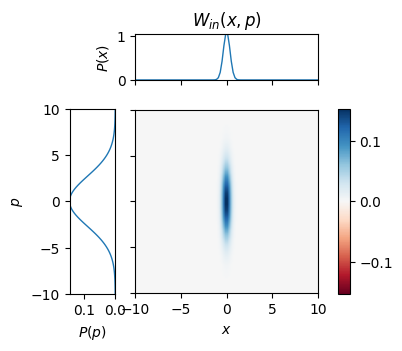

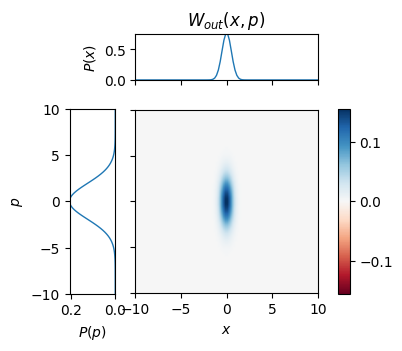

In [9]:
#Teleport a squeezed vacuum state through the EPR state
sqz = State(1)
r = 1
phi1 = 0
phi2 = 0

sqz.apply_symplectic(xxpp_to_xpxp(squeezing(r,0)))
x = np.linspace(-10,10,100)
Win = sqz.get_wigner_log(x,x)

state_teleport = teleportation_circuit_EPR(r, phi1, phi2, sqz)
print('purity of output state',overlap_log(state_teleport,state_teleport))
print('fidelity of inital state and teleported state,', overlap_log(sqz, state_teleport))

Wout = state_teleport.get_wigner_log(x,x)
fig, ax, axx, axp, axc = plot_wigner_marginals(Win,x,x,)
axx.set_title(r'$W_{in}(x,p)$')
plt.show()
fig, ax, axx, axp, axc = plot_wigner_marginals(Wout,x,x)
axx.set_title('$W_{out}(x,p)$')
plt.show()


purity of output state 1.0
fidelity of inital state and teleported state, 1.0


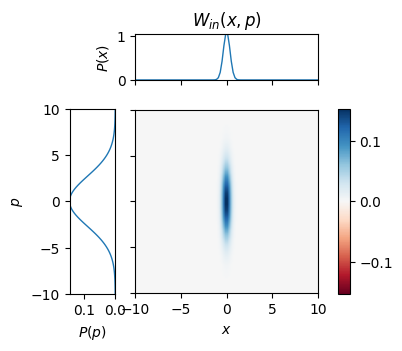

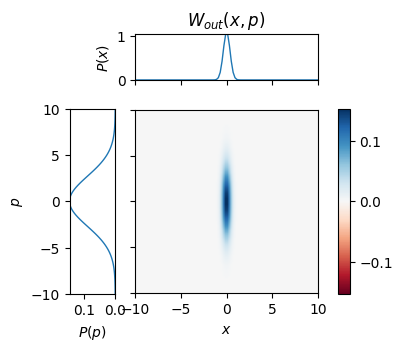

In [10]:
#Teleport a squeezed vacuum state through the cluster state
sqz = State(1)
r = 1
g = 1
phi1 = 0
phi2 = 0

sqz.apply_symplectic(xxpp_to_xpxp(squeezing(r,0)))
x = np.linspace(-10,10,100)
Win = sqz.get_wigner_log(x,x)

state_teleport = teleportation_circuit_cluster(r, g,phi1,phi2, sqz)
print('purity of output state',overlap_log(state_teleport,state_teleport))
print('fidelity of inital state and teleported state,', overlap_log(sqz, state_teleport))

Wout = state_teleport.get_wigner_log(x,x)
fig, ax, axx, axp, axc = plot_wigner_marginals(Win,x,x)
axx.set_title('$W_{in}(x,p)$')
plt.show()
fig, ax, axx, axp, axc =plot_wigner_marginals(Wout,x,x)
axx.set_title('$W_{out}(x,p)$')
plt.show()

In [11]:
#Compare teleportation of sqz vacuum through an EPR state and a cluster state

r_in = 1
rs = np.linspace(0,2,100)
phi1 = -np.pi/4
phi2 = np.pi/4

state_in = State(1)
state_in.apply_symplectic(xxpp_to_xpxp(squeezing(r_in, 0)))

ts = np.linspace(0,1,100)

fid = np.zeros((100,100))
norm1 = np.zeros((100,100))
norm2 = np.zeros((100,100))

for i, r in enumerate(rs):
    for j, t in enumerate(ts):

        state_EPR = teleportation_circuit_EPR(r, phi1,phi2, state_in)
        state_cluster = teleportation_circuit_cluster(r, t, phi1,phi2, state_in)

        fid[i,j] = overlap_log(state_EPR,state_cluster)
        norm1[i,j] = state_EPR.norm
        norm2[i,j] = state_cluster.norm


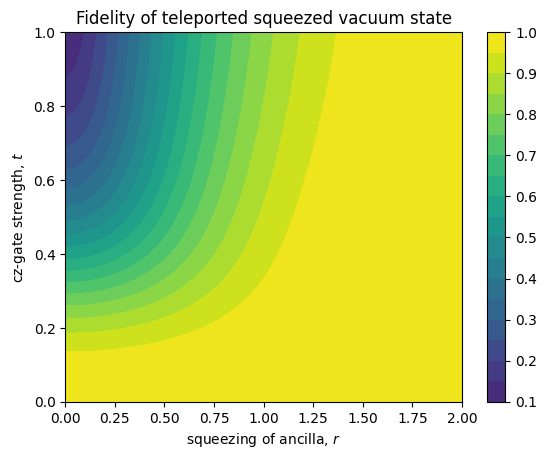

In [12]:
import matplotlib as mpl
norm = mpl.colors.Normalize(vmin=0, vmax=1)
levels = [0,0.2,0.4,0.6,0.8,1.0]
plt.contourf(rs,ts,fid,norm=norm,levels=20)
plt.colorbar()
plt.xlabel('squeezing of ancilla, $r$')
plt.ylabel('cz-gate strength, $t$')
plt.title('Fidelity of teleported squeezed vacuum state')
plt.show()


In [13]:
print(np.max(norm1))
print(np.max(norm2))

0.1031410410454353
0.1591468241153998


purity of output state (1.0000000000000018-3.009868527182426e-17j)
fidelity of inital state and teleported state, (0.4464243205103899+6.519641525430909e-18j)


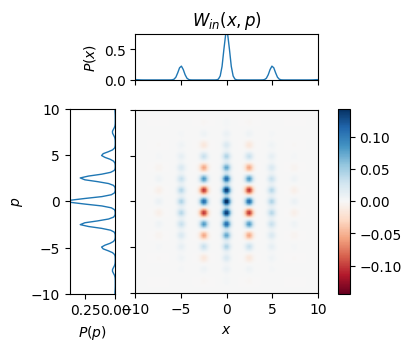

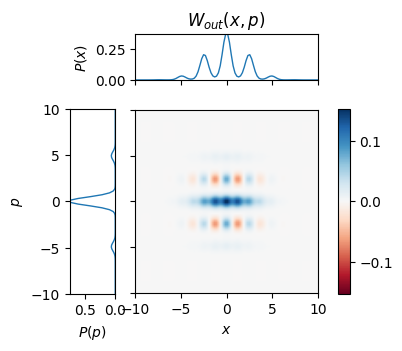

In [14]:
#Teleport a gkp state

gkp1 = prepare_gkp_bosonic([0,0],0.1)
gkp1.covs = np.array([gkp1.covs[0]]) #The covs repeat, just use 1
Win = gkp1.get_wigner_log(x,x)

r = 1.5
phi1 = np.pi/4
phi2 = -np.pi/4

state_teleport = teleportation_circuit_EPR(r, phi1, phi2, gkp1)
print('purity of output state',overlap_log(state_teleport,state_teleport))
print('fidelity of inital state and teleported state,', overlap_log(gkp1, state_teleport))
x = np.linspace(-10,10,100)
Wout = state_teleport.get_wigner_log(x,x)
fig, ax, axx, axp, axc = plot_wigner_marginals(Win.real,x,x)
axx.set_title(r'$W_{in}(x,p)$')
plt.show()
fig, ax, axx, axp,axc = plot_wigner_marginals(Wout.real,x,x,)
axx.set_title(r'$W_{out}(x,p)$')
plt.show()


purity of output state (0.9999999999998096+0j)
fidelity of inital state and teleported state, (0.432402647435163+0j)


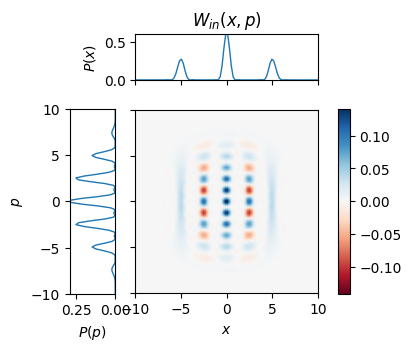

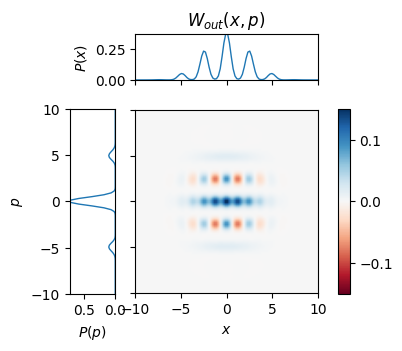

fidelity of output state to expected gate operation (0.8594556999704398+0j)


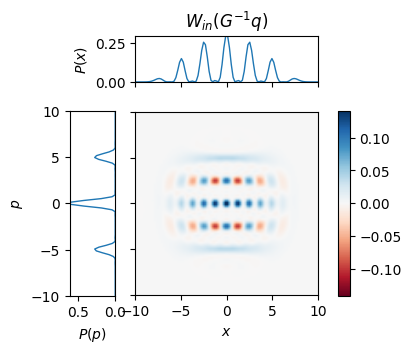

In [15]:
#Teleport another gkp state

gkp2 = prepare_gkp_nonlinear_sqz(20,'0')
Win = gkp2.get_wigner_log(x,x)

r = 1.5
phi1 = np.pi/4
phi2 = -np.pi/4


state_teleport = teleportation_circuit_EPR(r,phi1,phi2, gkp2)
print('purity of output state',overlap_log(state_teleport,state_teleport))
print('fidelity of inital state and teleported state,', overlap_log(gkp2, state_teleport))
x = np.linspace(-10,10,100)
Wout = state_teleport.get_wigner_log(x,x)
fig, ax, axx, axp, axc = plot_wigner_marginals(Win.real,x,x,)
axx.set_title(r'$W_{in}(x,p)$')
plt.show()
fig, ax, axx, axp, axc = plot_wigner_marginals(Wout.real,x,x,)
axx.set_title('$W_{out}(x,p)$')
plt.show()

#Expected operation
G = single_mode_teleport_gate(phi1,phi2)
gkp2.apply_symplectic(G)
print('fidelity of output state to expected gate operation', overlap_log(state_teleport, gkp2))

Wexpect = gkp2.get_wigner_log(x,x)
fig, ax, axx, axp, axc = plot_wigner_marginals(Wexpect.real,x,x,)
axx.set_title(r'$W_{in}(G^{-1} q)$')
plt.show()



purity of output state (0.9999999999987481+0j)
fidelity of inital state and teleported state, (0.4858592154669348+0j)


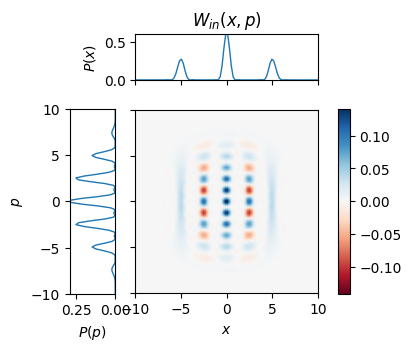

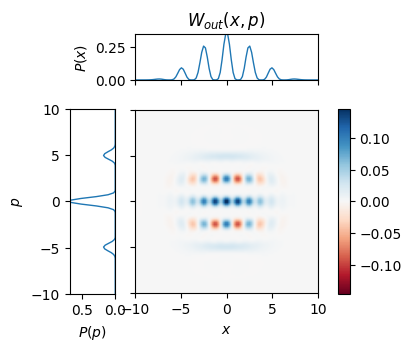

fidelity of output state to expected gate operation (0.9567996422691317+0j)


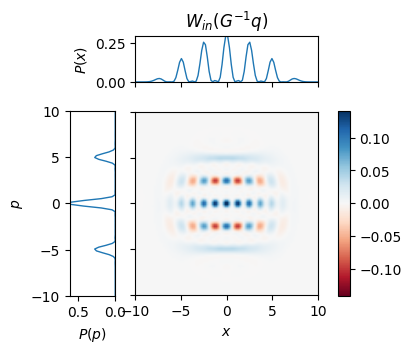

In [16]:
#Teleport a gkp state through the cluster

gkp2 = prepare_gkp_nonlinear_sqz(20,'0')
Win = gkp2.get_wigner_log(x,x)

phi1 = -np.pi/4
phi2 = np.pi/4
r = 1.5
g = 1

state_teleport = teleportation_circuit_cluster(r,g,phi1,phi2, gkp2)
print('purity of output state',overlap_log(state_teleport,state_teleport))
print('fidelity of inital state and teleported state,', overlap_log(gkp2, state_teleport))
x = np.linspace(-10,10,100)
Wout = state_teleport.get_wigner_log(x,x)
fig, ax, axx, axp, axc = plot_wigner_marginals(Win.real,x,x,)
axx.set_title(r'$W_{in}(x,p)$')
plt.show()
fig, ax, axx, axp, axc = plot_wigner_marginals(Wout.real,x,x,)
axx.set_title('$W_{out}(x,p)$')
plt.show()

#Expected operation
G = single_mode_teleport_gate(phi1,phi2)
gkp2.apply_symplectic(G)
print('fidelity of output state to expected gate operation', overlap_log(state_teleport, gkp2))


Wexpect = gkp2.get_wigner_log(x,x)
fig, ax, axx, axp, axc = plot_wigner_marginals(Wexpect.real,x,x)
axx.set_title(r'$W_{in}(G^{-1} q)$')
plt.show()

In [17]:
#Compare the teleported output state through an EPR state and a cluster state
r_in = 1.5
rs = np.linspace(0,2,50)
phi1 = -np.pi/4
phi2 = np.pi/4

state_in = prepare_gkp_bosonic([0,0],0.1)
state_in.covs = np.array([gkp1.covs[0]]) #The covs repeat, just use 1

ts = np.linspace(0,1,50)

fid = np.zeros((len(rs),len(ts)))

for i, r in enumerate(rs):
    for j, t in enumerate(ts):

        state_EPR = teleportation_circuit_EPR(r, phi1,phi2, state_in)
        state_cluster = teleportation_circuit_cluster(r, t, phi1,phi2, state_in)
        fid[i,j] = overlap_log(state_EPR,state_cluster)


/var/folders/m2/hpgw6ky53rbgdd595zcgg_bm0000gp/T/ipykernel_75783/3367641945.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
  fid[i,j] = overlap_log(state_EPR,state_cluster)


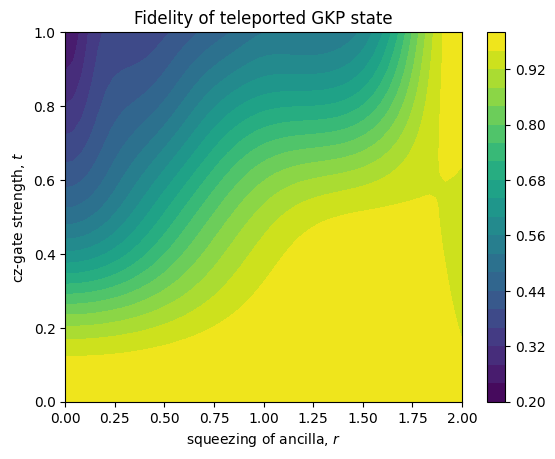

In [18]:
plt.contourf(rs,ts,fid,levels=20)
plt.colorbar()
plt.xlabel('squeezing of ancilla, $r$')
plt.ylabel('cz-gate strength, $t$')
plt.title('Fidelity of teleported GKP state')
plt.show()


purity of output state (1.0000000000000018+0j)
fidelity of inital state and teleported state, (0.7923271336642107+0j)


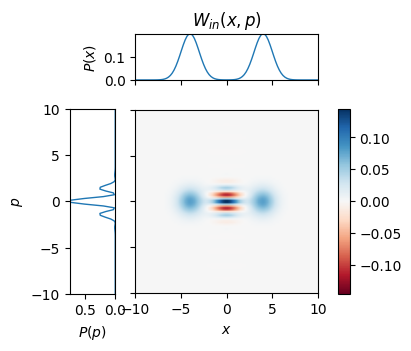

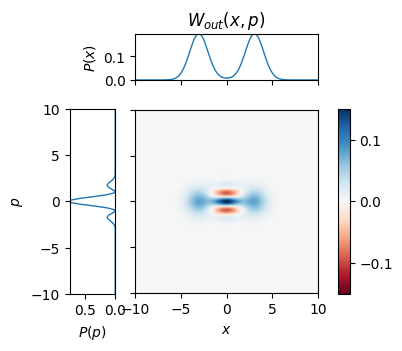

In [19]:
## Teleporting a cat

cat = prepare_sqz_cat_coherent(0,2,0)
cat.get_norm() #Normalize
Win = cat.get_wigner_log(x,x)

r = 1
phi1 = np.pi/2
phi2 = 0

state_teleport = teleportation_circuit_EPR(r, phi1, phi2, cat)
print('purity of output state',overlap_log(state_teleport,state_teleport))
print('fidelity of inital state and teleported state,', overlap_log(cat, state_teleport))
x = np.linspace(-10,10,100)
Wout = state_teleport.get_wigner_log(x,x)
fig, ax, axx, axp, axc = plot_wigner_marginals(Win.real,x,x)
axx.set_title(r'$W_{in}(x,p)$')
plt.show()
fig, ax, axx, axp, axc = plot_wigner_marginals(Wout.real,x,x)
axx.set_title(r'$W_{out}(x,p)$')
plt.show()


purity of output state (1.0000000000000044+0j)
fidelity of inital state and teleported state, (0.8533023877310614+0j)


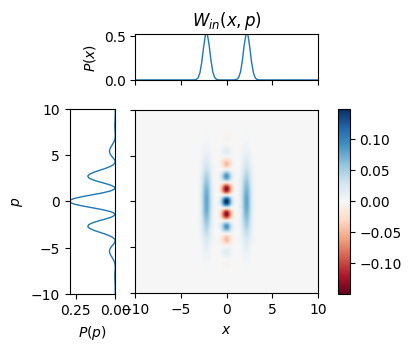

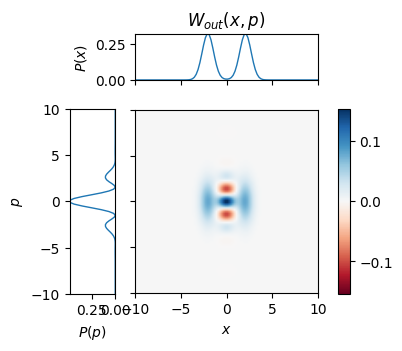

In [20]:
## Teleporting a squeezed cat

cat = prepare_sqz_cat_coherent(1,3,0)
cat.get_norm() #Normalize
Win = cat.get_wigner_log(x,x)

r = 1
phi1 = np.pi/2
phi2 = 0

state_teleport = teleportation_circuit_EPR(r, phi1, phi2, cat)
print('purity of output state',overlap_log(state_teleport,state_teleport))
print('fidelity of inital state and teleported state,', overlap_log(cat, state_teleport))
x = np.linspace(-10,10,100)
Wout = state_teleport.get_wigner_log(x,x)
fig, ax, axx, axp, axc = plot_wigner_marginals(Win.real,x,x,)
axx.set_title(r'$W_{in}(x,p)$')
plt.show()
fig, ax, axx, axp, axc = plot_wigner_marginals(Wout.real,x,x,)
axx.set_title(r'$W_{out}(x,p)$')
plt.show()


In [21]:
def test_cat_teleport(r, phi1, n2, input_state, m1 = 0):
    """
    Args:
        r : float, squeezing of EPR state
        n2 : photon number
        phi1 : homodyne angle 1
        input_state : input state  (bosonicplus.base.State)
        m1 : homodyne measurement result
        
    """
    S2 = xxpp_to_xpxp(squeezing(r,0))
    S3 = xxpp_to_xpxp(squeezing(r,np.pi))
    BS = xxpp_to_xpxp(beam_splitter(-np.pi/4,0))

    ## hack to tensor product two mode vacuum with the input state
    new_means = np.array([np.concatenate([i, np.zeros(4)]) for i in input_state.means])
    new_covs = np.array([np.eye(6)])
    new_covs[:,0:2,0:2] = input_state.covs
    state = State(3)
    state.update_data([new_means, new_covs, input_state.log_weights, input_state.num_k])
    
    #make the ancilla EPR state
    state.apply_symplectic_fast(S2, [1])
    state.apply_symplectic_fast(S3, [2])
    state.apply_symplectic_fast(BS, [1,2])

    state.apply_symplectic_fast(BS, [0,1])

    state.post_select_homodyne(0, phi1, m1)
    state.post_select_fock_coherent(0, n2)

    return state


purity of output state (0.9999999999999987+4.10094807678476e-17j)
fidelity of inital state and teleported state, (0.15668320204859024+0.4380622979250861j)


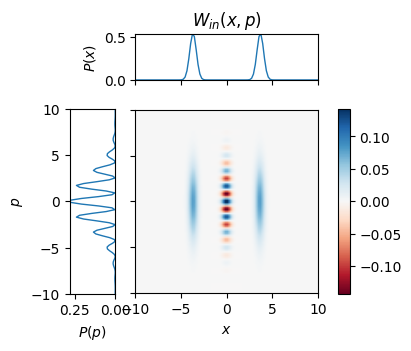

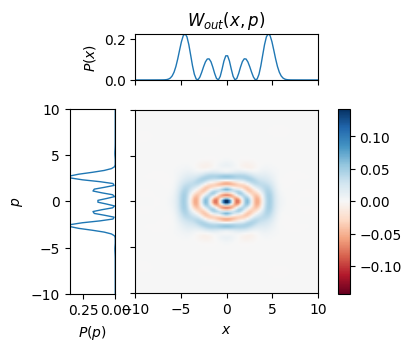

In [22]:
cat = prepare_sqz_cat_coherent(1,5,0)
cat.get_norm() #Normalize
Win = cat.get_wigner_log(x,x)

r = 1
phi1 = np.pi/2
n = 10

state_teleport = test_cat_teleport(r, phi1, n, cat)
print('purity of output state',overlap_log(state_teleport,state_teleport))
print('fidelity of inital state and teleported state,', overlap_log(cat, state_teleport))
x = np.linspace(-10,10,100)
Wout = state_teleport.get_wigner_log(x,x)
fig, ax ,axx, axp, axc = plot_wigner_marginals(Win.real,x,x,)
axx.set_title(r'$W_{in}(x,p)$')
plt.show()
fig, ax ,axx, axp, axc = plot_wigner_marginals(Wout.real,x,x,)
axx.set_title('$W_{out}(x,p)$')
plt.show()